# Data Exploration for GuitarTab Project

This notebook explores the Guitar Chords V2 and GuitarSet datasets to understand their structure, distribution, and characteristics.
01_data_exploration is focused solely on exploration
## Table of Contents
1. [Import Libraries](#Import-Libraries)
2. [Define Paths and Parameters](#Define-Paths-and-Parameters)
3. [Load Sample Audio Files](#Load-Sample-Audio-Files)
4. [Visualize Waveforms](#Visualize-Waveforms)
5. [Compute and Visualize Spectrograms](#Compute-and-Visualize-Spectrograms)
6. [Class Distribution](#Class-Distribution)
7. [Conclusion](#Conclusion)

In [1]:
# 1. Import Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from src.data_preprocessing import get_file_paths, encode_labels, create_tf_datasets
from src.models import create_crnn_model
from src.data_preprocessing import load_wav_16k_mono, standardize_audio_length, compute_mel_spectrogram
import librosa
import pandas as pd



## 2. Define Paths and Parameters

Setting the paths to the datasets and defining any necessary parameters.

In [2]:
# 2. Define Paths and Parameters
DATA_DIR = r"C:\Users\User\Documents\GitHub\GuitarTab\Guitar_Chords_V2"
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Test')
chords = ['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']

In [3]:
def verify_paths():
    required_chords = ['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
    
    # Check base directories
    assert os.path.exists(DATA_DIR), f"Missing base directory: {DATA_DIR}"
    assert os.path.exists(TRAIN_DIR), f"Missing training directory: {TRAIN_DIR}"
    assert os.path.exists(TEST_DIR), f"Missing test directory: {TEST_DIR}"
    
    # Check chord subfolders
    for split in [TRAIN_DIR, TEST_DIR]:
        for chord in required_chords:
            chord_dir = os.path.join(split, chord)
            assert os.path.exists(chord_dir), f"Missing chord directory: {chord_dir}"
            assert len(os.listdir(chord_dir)) > 0, f"No files in {chord_dir}"
    
    print("All paths validated successfully!")

verify_paths()

All paths validated successfully!


## 3. Load Sample Audio Files

Load a few sample audio files from each dataset to inspect their content.

In [4]:
# 3. Load Sample Audio Files
sample_chord = 'Am'
sample_file = os.path.join(TRAIN_DIR, sample_chord, f'{sample_chord}_AcusticPlug26_1.wav')  # Update filename as needed
wav = load_wav_16k_mono(sample_file)
print(f"Audio Loaded: {sample_file}, Duration: {len(wav)/16000:.2f} seconds")

Audio Loaded: C:\Users\User\Documents\GitHub\GuitarTab\Guitar_Chords_V2\Training\Am\Am_AcusticPlug26_1.wav, Duration: 4.16 seconds


## 4. Visualize Waveforms

Plot the waveform of the sample audio to understand its amplitude variations over time.

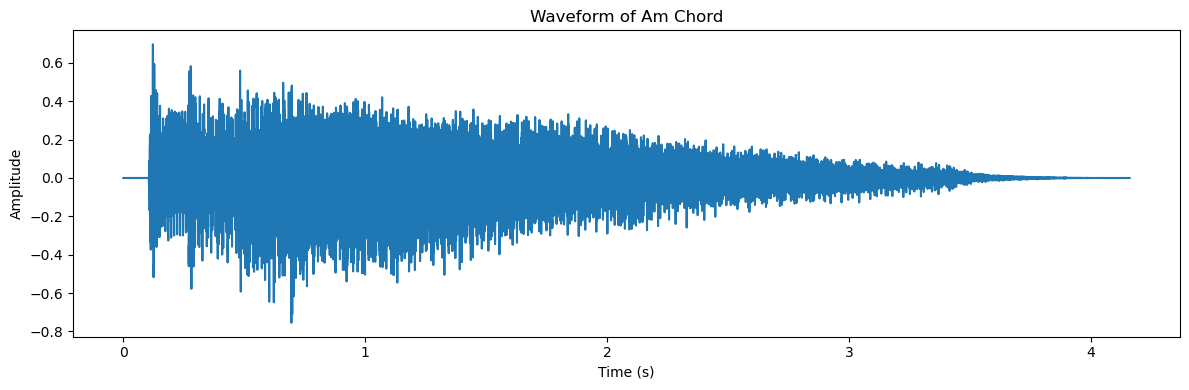

In [5]:
# 4. Visualize Waveforms
def plot_waveform(wav, sr=16000, title="Waveform"):
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(wav))/sr, wav)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

plot_waveform(wav, title=f"Waveform of {sample_chord} Chord")

## 5. Compute and Visualize Spectrograms

Convert the audio waveform into a spectrogram and visualize it.

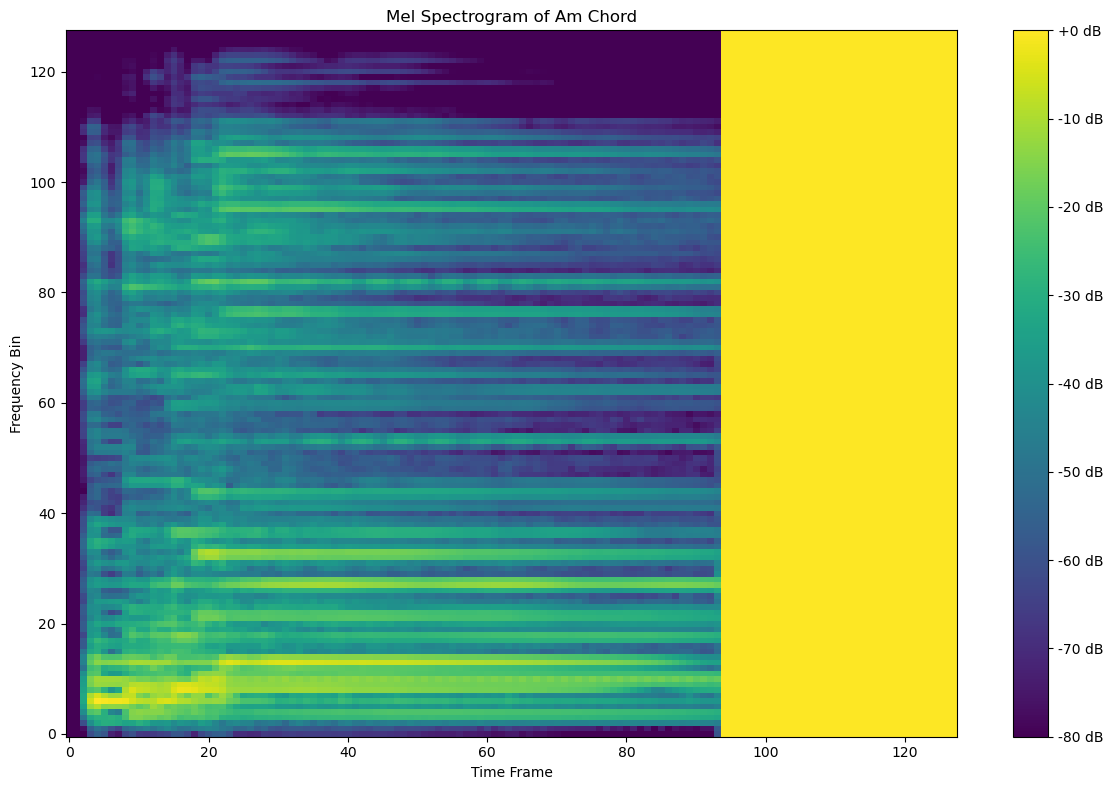

In [6]:
# 5. Compute and Visualize Spectrograms
def plot_spectrogram(spectrogram, title="Spectrogram"):
    plt.figure(figsize=(12, 8))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel("Time Frame")
    plt.ylabel("Frequency Bin")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Standardize and compute mel spectrogram
wav_standardized = standardize_audio_length(wav)
mel_spec = compute_mel_spectrogram(wav_standardized)
plot_spectrogram(mel_spec, title=f"Mel Spectrogram of {sample_chord} Chord")


## 6. Class Distribution

Analyze the distribution of chords in the Guitar Chords V2 dataset.

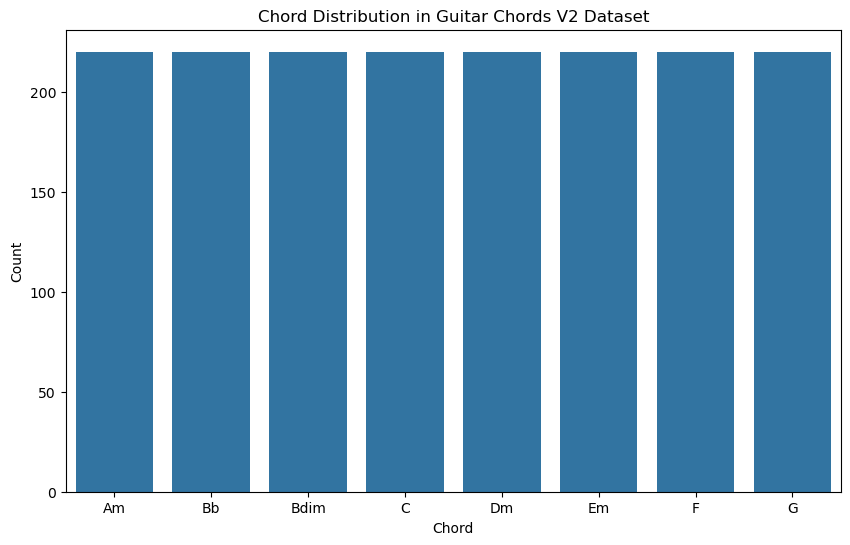

Total samples: 1760
Training samples: 1440
Testing samples: 320

Chord distribution:
  Am: 220 samples (12.5%)
  Bb: 220 samples (12.5%)
  Bdim: 220 samples (12.5%)
  C: 220 samples (12.5%)
  Dm: 220 samples (12.5%)
  Em: 220 samples (12.5%)
  F: 220 samples (12.5%)
  G: 220 samples (12.5%)


In [7]:
# 6. Class Distribution
import glob
def get_all_files(dataset_path, chords):
    files = []
    labels = []
    for chord in chords:
        chord_path = os.path.join(dataset_path, chord, '*.wav')
        chord_files = glob.glob(chord_path)
        files += chord_files
        labels += [chord] * len(chord_files)
    return files, labels

# Get train and test files
train_files, train_labels = get_all_files(TRAIN_DIR, chords)
test_files, test_labels = get_all_files(TEST_DIR, chords)

# Combine and create a DataFrame
all_labels = train_labels + test_labels
df = pd.DataFrame({'Chord': all_labels})

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Chord', order=chords)
plt.title('Chord Distribution in Guitar Chords V2 Dataset')
plt.xlabel('Chord')
plt.ylabel('Count')
plt.show()

# 7. Conclusion
print(f"Total samples: {len(all_labels)}")
print(f"Training samples: {len(train_labels)}")
print(f"Testing samples: {len(test_labels)}")
print("\nChord distribution:")
for chord in chords:
    count = df['Chord'].value_counts()[chord]
    percentage = 100 * count / len(df)
    print(f"  {chord}: {count} samples ({percentage:.1f}%)")